In [1]:
# Instalação de bibliotecas (se necessário)
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# Carregar os dados
from google.colab import files
uploaded = files.upload()  # Faça upload do arquivo Main_database.xlsx

# Ler o arquivo Excel
df = pd.read_excel('Main_database (2).xlsx')

# Converter as colunas para strings para facilitar a busca
df.columns = [str(col) for col in df.columns]

# Identificar colunas relevantes
genero_cols = [col for col in df.columns if 'Genero' in col]
genero_col = genero_cols[0] if genero_cols else None

cor_raca_cols = [col for col in df.columns if 'Cor/raca/etnia' in col]
cor_raca_col = cor_raca_cols[0] if cor_raca_cols else None

uf_cols = [col for col in df.columns if 'uf onde mora' in col]
uf_col = uf_cols[0] if uf_cols else None

nivel_ensino_cols = [col for col in df.columns if 'Nivel de Ensino' in col]
nivel_ensino_col = nivel_ensino_cols[0] if nivel_ensino_cols else None

faixa_salarial_cols = [col for col in df.columns if 'Faixa salarial' in col]
faixa_salarial_col = faixa_salarial_cols[0] if faixa_salarial_cols else None

# Verificar se todas as colunas necessárias foram encontradas
print("Colunas identificadas:")
print(f"Gênero: {genero_col}")
print(f"Cor/Raça: {cor_raca_col}")
print(f"UF: {uf_col}")
print(f"Nível de Ensino: {nivel_ensino_col}")
print(f"Faixa Salarial: {faixa_salarial_col}")

Saving Main_database (2).xlsx to Main_database (2) (1).xlsx
Colunas identificadas:
Gênero: ('P1_b ', 'Genero')
Cor/Raça: ('P1_c ', 'Cor/raca/etnia')
UF: ('P1_i_1 ', 'uf onde mora')
Nível de Ensino: ('P1_l ', 'Nivel de Ensino')
Faixa Salarial: ('P2_h ', 'Faixa salarial')


In [4]:
# Selecionar apenas as colunas relevantes
features = [genero_col, cor_raca_col, uf_col, nivel_ensino_col]
target = faixa_salarial_col

# Criar um DataFrame com as colunas selecionadas
data = df[features + [target]].copy()

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(data.isnull().sum())

# Remover linhas com valores ausentes
data = data.dropna()
print(f"\nDimensões após remover valores ausentes: {data.shape}")

# Mapear UFs para regiões
regiao_mapping = {
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Adicionar coluna de região
data['Regiao'] = data[uf_col].map(regiao_mapping)

# Substituir UF por região
data = data.drop(columns=[uf_col])
features.remove(uf_col)
features.append('Regiao')

# Verificar distribuição da variável alvo
print("\nDistribuição da variável alvo (Faixa Salarial):")
print(data[target].value_counts(normalize=True) * 100)


Valores ausentes por coluna:
('P1_b ', 'Genero')               0
('P1_c ', 'Cor/raca/etnia')       0
('P1_i_1 ', 'uf onde mora')     124
('P1_l ', 'Nivel de Ensino')      0
('P2_h ', 'Faixa salarial')     540
dtype: int64

Dimensões após remover valores ausentes: (4650, 5)

Distribuição da variável alvo (Faixa Salarial):
('P2_h ', 'Faixa salarial')
de R$ 8.001/mês a R$ 12.000/mês     21.741935
de R$ 4.001/mês a R$ 6.000/mês      15.913978
de R$ 12.001/mês a R$ 16.000/mês    13.698925
de R$ 6.001/mês a R$ 8.000/mês      13.526882
de R$ 3.001/mês a R$ 4.000/mês       7.505376
de R$ 16.001/mês a R$ 20.000/mês     6.774194
de R$ 2.001/mês a R$ 3.000/mês       6.193548
de R$ 1.001/mês a R$ 2.000/mês       4.559140
de R$ 20.001/mês a R$ 25.000/mês     4.021505
de R$ 25.001/mês a R$ 30.000/mês     2.516129
de R$ 30.001/mês a R$ 40.000/mês     1.612903
Acima de R$ 40.001/mês               1.333333
Menos de R$ 1.000/mês                0.580645
de R$ 101/mês a R$ 2.000/mês         0.021505
Name

In [5]:
# Simplificar as categorias de faixa salarial para melhorar o desempenho do modelo
# Vamos agrupar em 5 categorias: Muito Baixa, Baixa, Média, Alta, Muito Alta

def categorizar_salario(faixa):
    if 'Não' in faixa or 'não' in faixa or 'Prefiro' in faixa:
        return 'Não Informado'
    elif 'Até' in faixa or '1.000' in faixa or '2.000' in faixa:
        return 'Muito Baixa (Até R$ 2.000)'
    elif '3.000' in faixa or '4.000' in faixa:
        return 'Baixa (R$ 2.001 a R$ 4.000)'
    elif '6.000' in faixa or '8.000' in faixa:
        return 'Média (R$ 4.001 a R$ 8.000)'
    elif '12.000' in faixa or '16.000' in faixa:
        return 'Alta (R$ 8.001 a R$ 16.000)'
    else:
        return 'Muito Alta (Acima de R$ 16.000)'

data['Faixa_Salarial_Categorizada'] = data[target].apply(categorizar_salario)

# Remover a categoria "Não Informado"
data = data[data['Faixa_Salarial_Categorizada'] != 'Não Informado']

# Verificar a nova distribuição
print("\nDistribuição da faixa salarial categorizada:")
print(data['Faixa_Salarial_Categorizada'].value_counts(normalize=True) * 100)

# Definir a nova variável alvo
target = 'Faixa_Salarial_Categorizada'

# Verificar distribuições das variáveis preditoras
for feature in features:
    print(f"\nDistribuição de {feature}:")
    print(data[feature].value_counts(normalize=True) * 100)


Distribuição da faixa salarial categorizada:
Faixa_Salarial_Categorizada
Média (R$ 4.001 a R$ 8.000)        43.139785
Muito Baixa (Até R$ 2.000)         26.903226
Muito Alta (Acima de R$ 16.000)    16.258065
Baixa (R$ 2.001 a R$ 4.000)        13.698925
Name: proportion, dtype: float64

Distribuição de ('P1_b ', 'Genero'):
('P1_b ', 'Genero')
Masculino               76.172043
Feminino                23.440860
Prefiro não informar     0.236559
Outro                    0.150538
Name: proportion, dtype: float64

Distribuição de ('P1_c ', 'Cor/raca/etnia'):
('P1_c ', 'Cor/raca/etnia')
Branca                  64.924731
Parda                   24.043011
Preta                    7.161290
Amarela                  2.774194
Prefiro não informar     0.580645
Outra                    0.279570
Indígena                 0.236559
Name: proportion, dtype: float64

Distribuição de ('P1_l ', 'Nivel de Ensino'):
('P1_l ', 'Nivel de Ensino')
Pós-graduação                 35.935484
Graduação/Bacharelado    

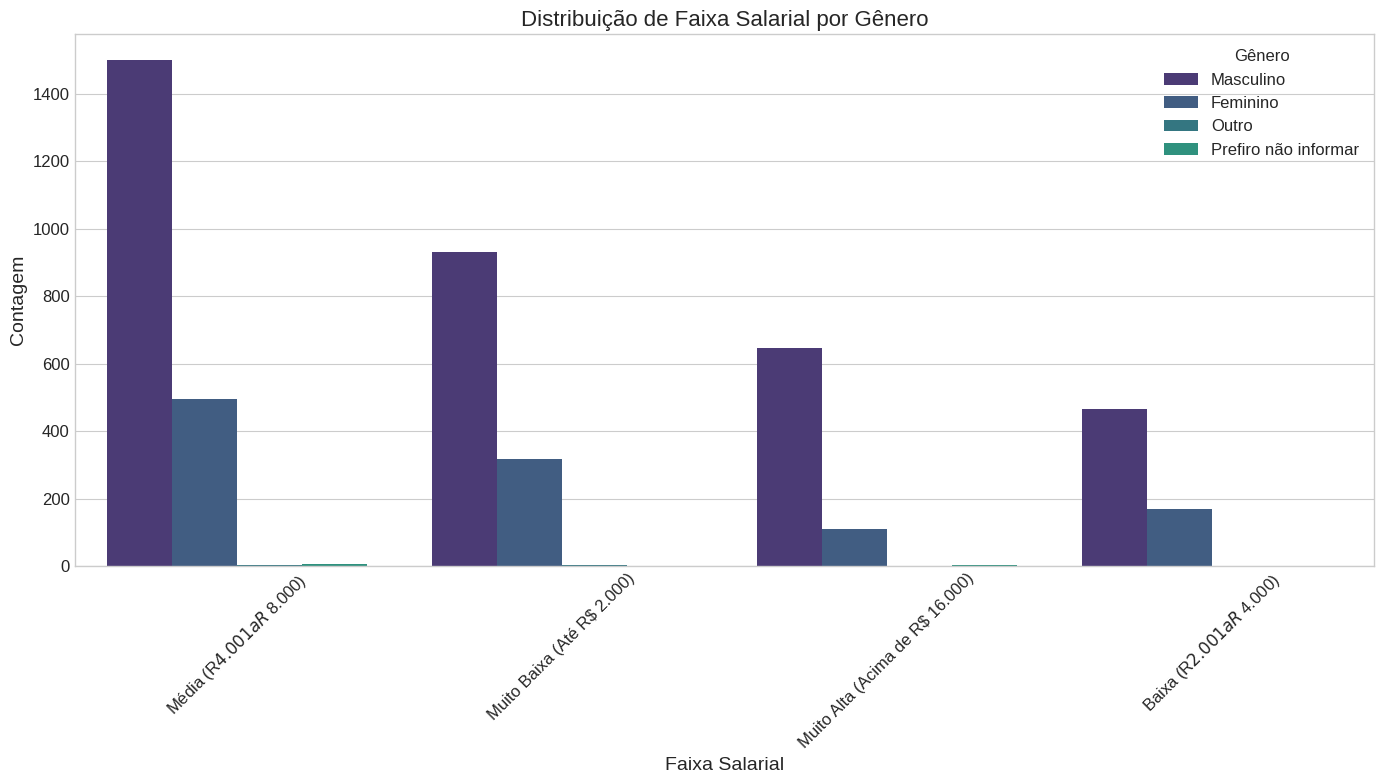

In [6]:
# Visualizar a relação entre gênero e faixa salarial
plt.figure(figsize=(14, 8))
sns.countplot(x='Faixa_Salarial_Categorizada', hue=genero_col, data=data)
plt.title('Distribuição de Faixa Salarial por Gênero', fontsize=16)
plt.xlabel('Faixa Salarial', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()

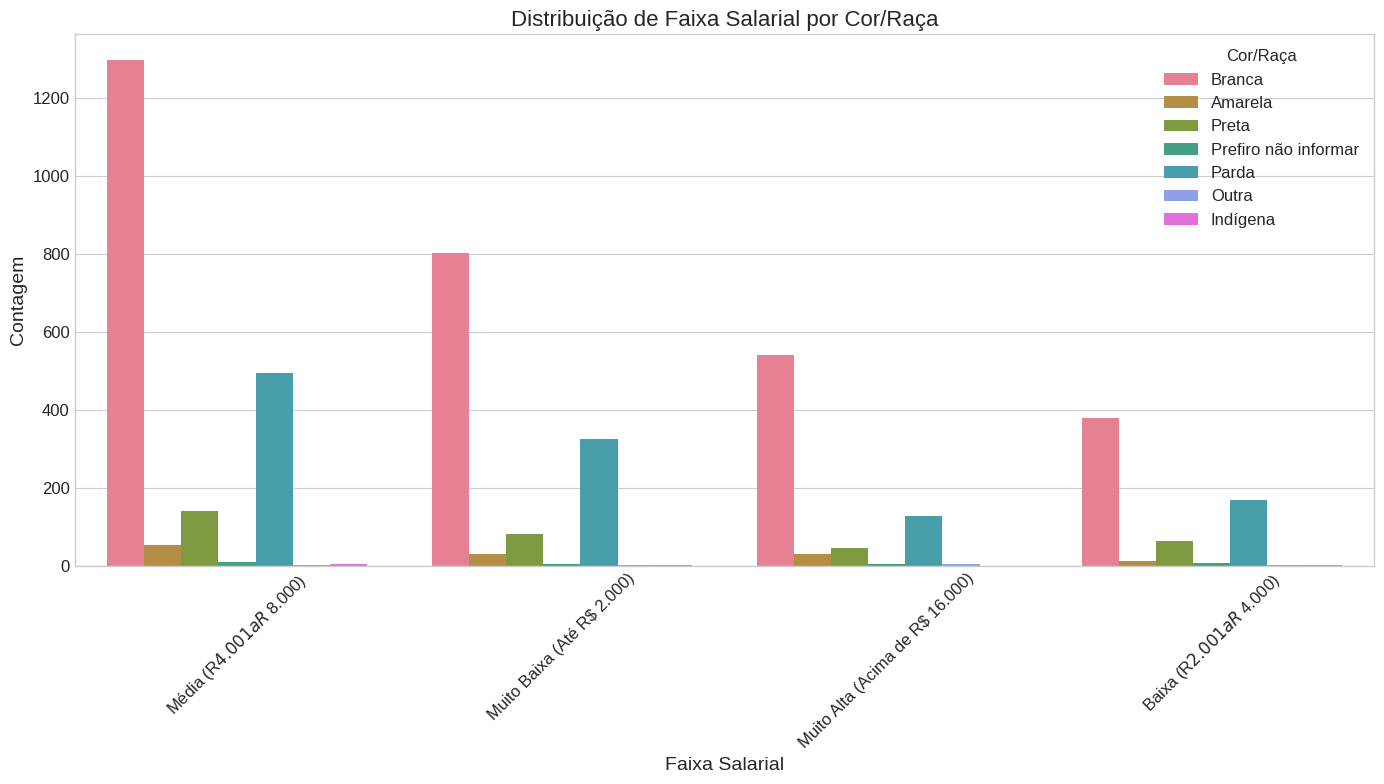

In [7]:
# Visualizar a relação entre cor/raça e faixa salarial
plt.figure(figsize=(14, 8))
sns.countplot(x='Faixa_Salarial_Categorizada', hue=cor_raca_col, data=data)
plt.title('Distribuição de Faixa Salarial por Cor/Raça', fontsize=16)
plt.xlabel('Faixa Salarial', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Cor/Raça')
plt.tight_layout()
plt.show()

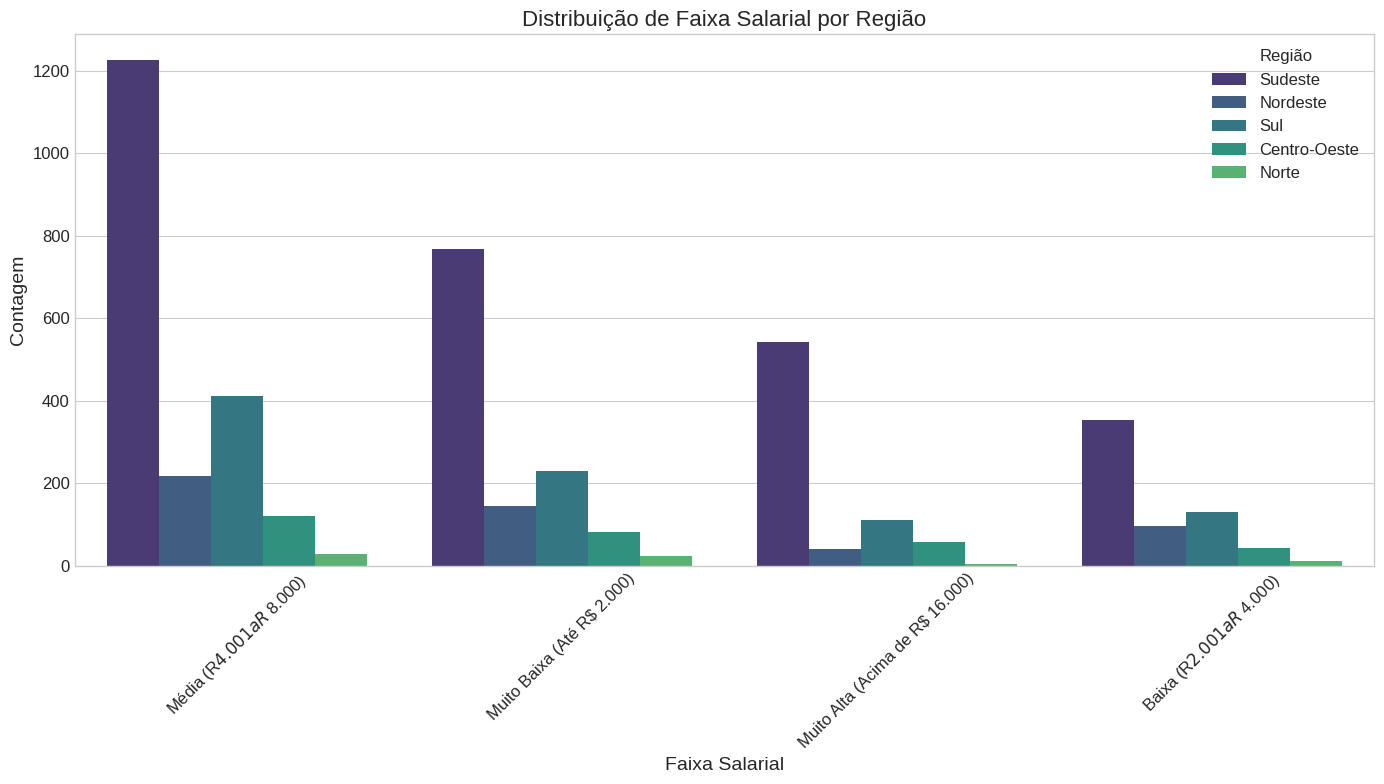

In [8]:
# Visualizar a relação entre região e faixa salarial
plt.figure(figsize=(14, 8))
sns.countplot(x='Faixa_Salarial_Categorizada', hue='Regiao', data=data)
plt.title('Distribuição de Faixa Salarial por Região', fontsize=16)
plt.xlabel('Faixa Salarial', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

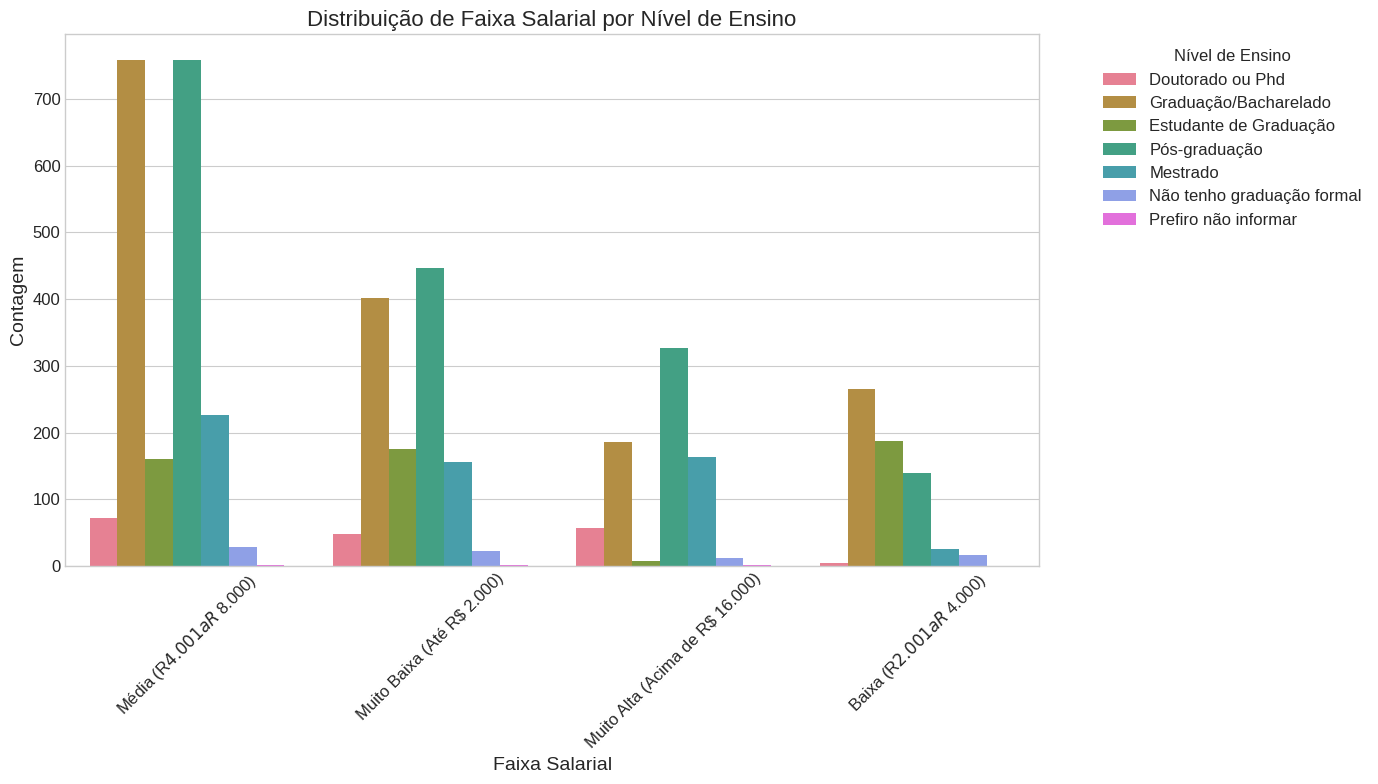

In [9]:
# Visualizar a relação entre nível de ensino e faixa salarial
plt.figure(figsize=(14, 8))
sns.countplot(x='Faixa_Salarial_Categorizada', hue=nivel_ensino_col, data=data)
plt.title('Distribuição de Faixa Salarial por Nível de Ensino', fontsize=16)
plt.xlabel('Faixa Salarial', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Nível de Ensino', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

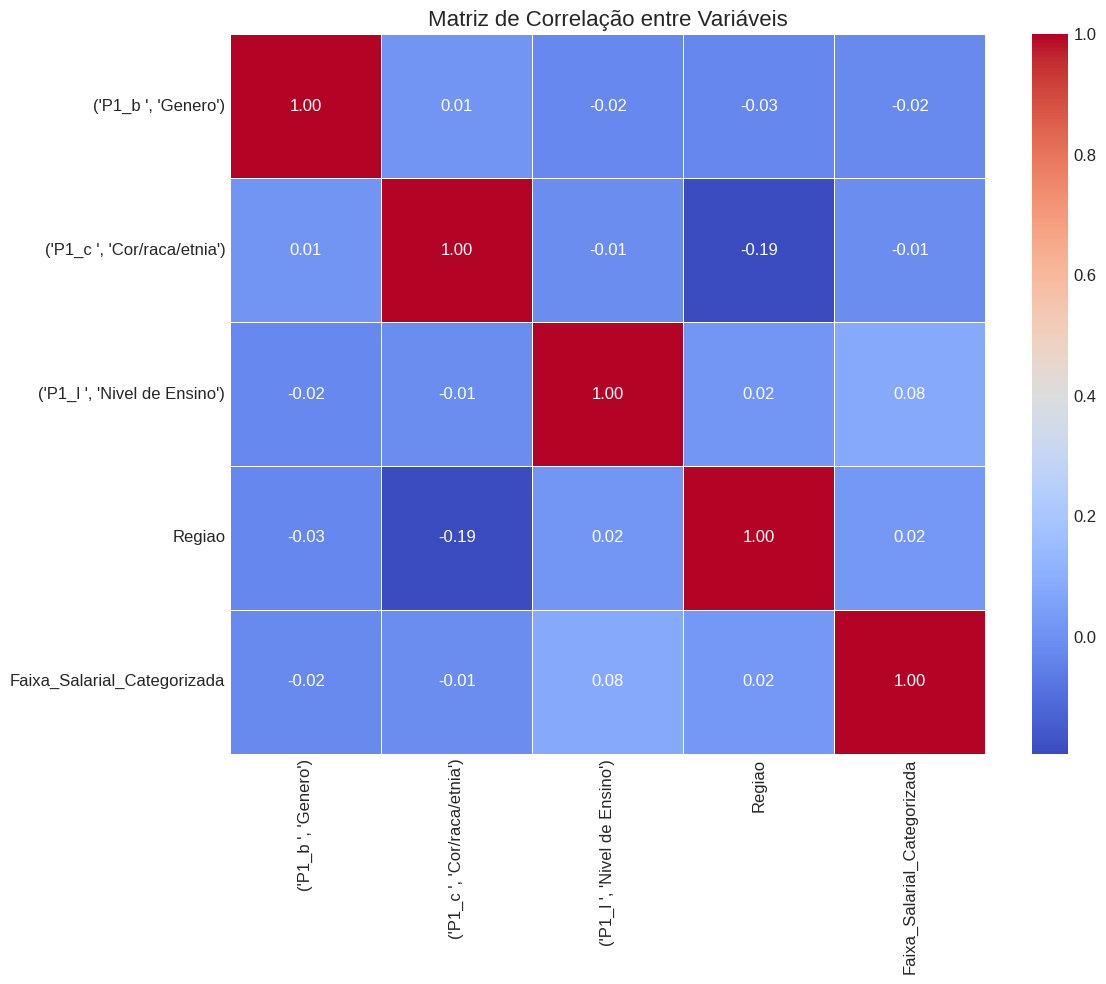

In [10]:
# Criar um heatmap para visualizar a correlação entre as variáveis categóricas
# Primeiro, precisamos codificar as variáveis categóricas
from sklearn.preprocessing import LabelEncoder

# Criar uma cópia dos dados para não modificar o DataFrame original
data_encoded = data.copy()

# Aplicar LabelEncoder a todas as colunas categóricas
label_encoders = {}
for col in features + [target]:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Calcular a matriz de correlação
corr_matrix = data_encoded[features + [target]].corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# Separar features e target
X = data[features]
y = data[target]

# Codificar a variável alvo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Mapear os valores codificados para as categorias originais
target_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
print("\nMapeamento da variável alvo:")
for code, category in target_mapping.items():
    print(f"{code}: {category}")

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nDimensões do conjunto de treino: {X_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}")

# Definir as colunas categóricas
categorical_features = features

# Criar um preprocessador para transformar as variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Verificar a distribuição da variável alvo nos conjuntos de treino e teste
print("\nDistribuição da variável alvo no conjunto de treino:")
for i in range(len(le_target.classes_)):
    print(f"{target_mapping[i]}: {(y_train == i).sum() / len(y_train) * 100:.2f}%")

print("\nDistribuição da variável alvo no conjunto de teste:")
for i in range(len(le_target.classes_)):
    print(f"{target_mapping[i]}: {(y_test == i).sum() / len(y_test) * 100:.2f}%")


Mapeamento da variável alvo:
0: Baixa (R$ 2.001 a R$ 4.000)
1: Muito Alta (Acima de R$ 16.000)
2: Muito Baixa (Até R$ 2.000)
3: Média (R$ 4.001 a R$ 8.000)

Dimensões do conjunto de treino: (3720, 4)
Dimensões do conjunto de teste: (930, 4)

Distribuição da variável alvo no conjunto de treino:
Baixa (R$ 2.001 a R$ 4.000): 13.68%
Muito Alta (Acima de R$ 16.000): 16.26%
Muito Baixa (Até R$ 2.000): 26.91%
Média (R$ 4.001 a R$ 8.000): 43.15%

Distribuição da variável alvo no conjunto de teste:
Baixa (R$ 2.001 a R$ 4.000): 13.76%
Muito Alta (Acima de R$ 16.000): 16.24%
Muito Baixa (Até R$ 2.000): 26.88%
Média (R$ 4.001 a R$ 8.000): 43.12%


In [12]:
# Criar o pipeline com o preprocessador e o modelo XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='multi:softprob', num_class=len(le_target.classes_),
                                     random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Definir os parâmetros para otimização
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Configurar a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Criar o GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Treinar o modelo
print("\nTreinando o modelo GBM com otimização de hiperparâmetros...")
grid_search.fit(X_train, y_train)

# Exibir os melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# Obter o melhor modelo
best_model = grid_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy:.4f}")

# Exibir o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))


Treinando o modelo GBM com otimização de hiperparâmetros...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Melhores parâmetros encontrados:
{'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Acurácia do modelo: 0.4194

Relatório de Classificação:
                                 precision    recall  f1-score   support

    Baixa (R$ 2.001 a R$ 4.000)       0.30      0.15      0.20       128
Muito Alta (Acima de R$ 16.000)       0.00      0.00      0.00       151
     Muito Baixa (Até R$ 2.000)       0.26      0.05      0.08       250
    Média (R$ 4.001 a R$ 8.000)       0.44      0.90      0.59       401

                       accuracy                           0.42       930
                      macro avg       0.25      0.27      0.22       930
                   weighted avg       0.30      0.42      0.30       930



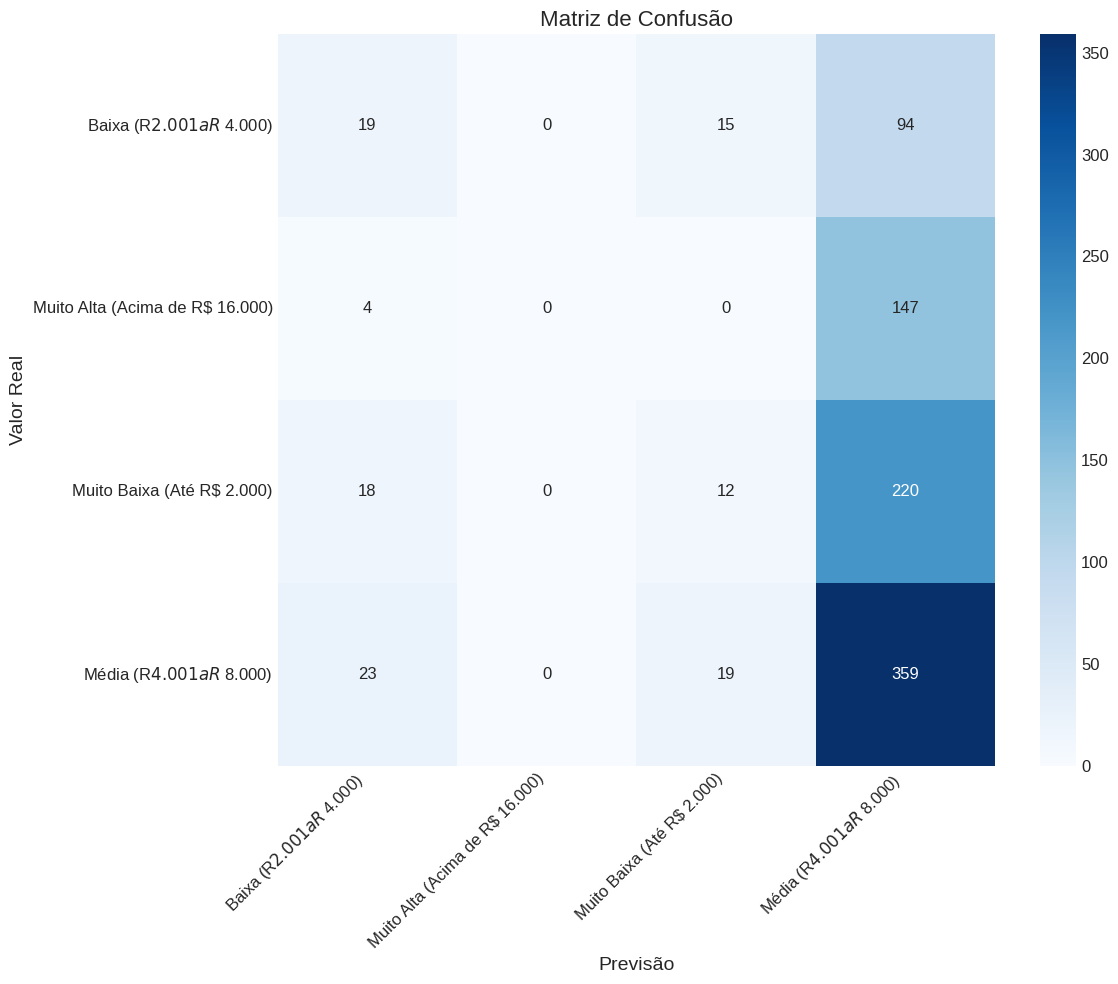

In [13]:
# Criar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Previsão', fontsize=14)
plt.ylabel('Valor Real', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

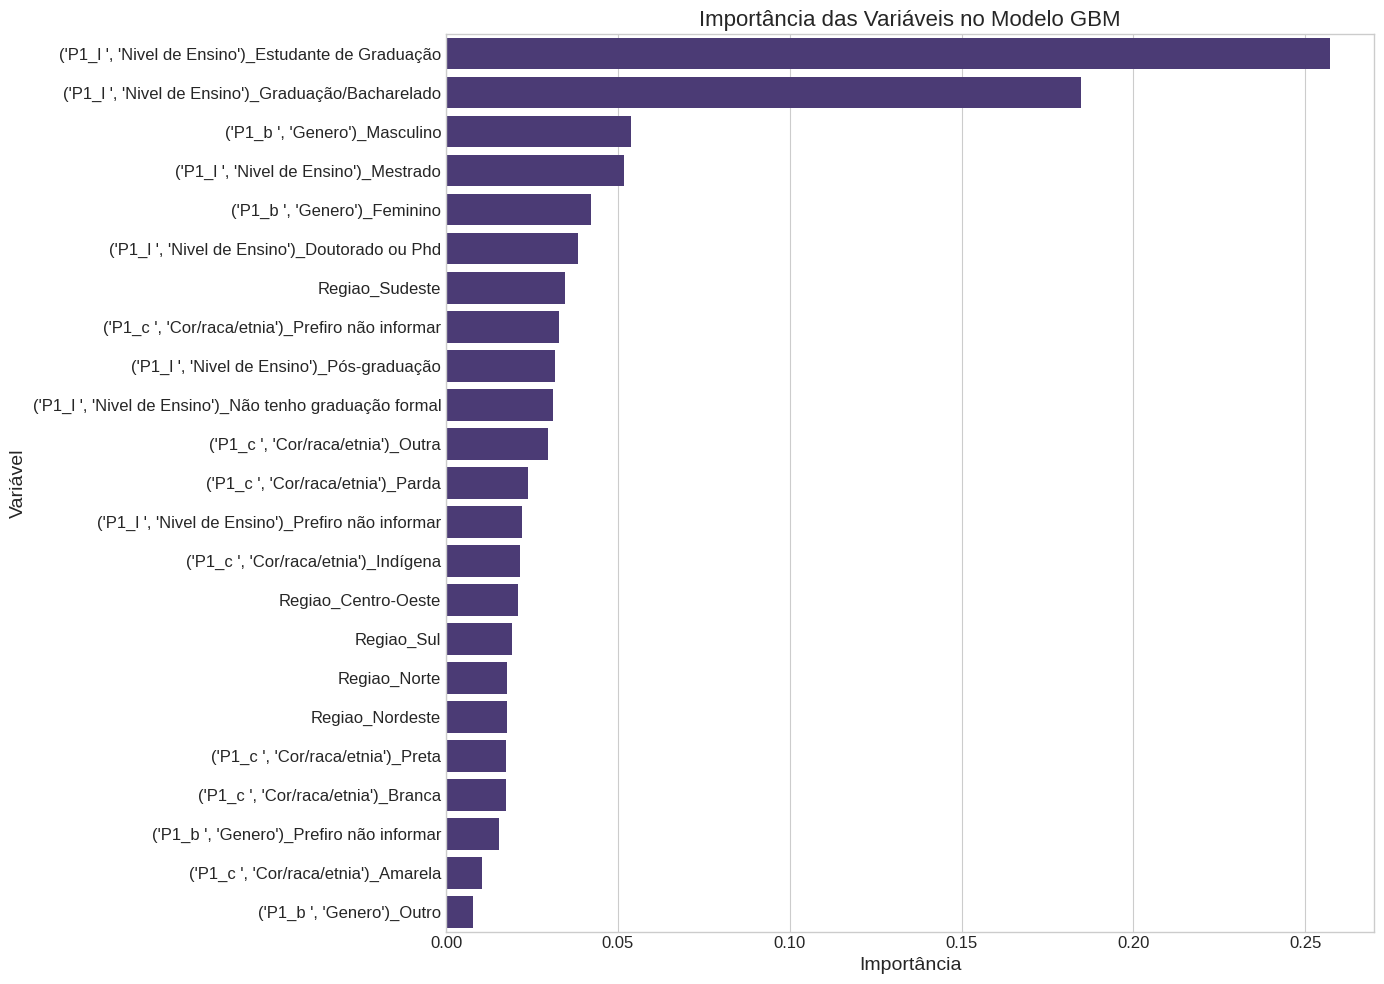

In [14]:
# Obter o modelo XGBoost do pipeline
xgb_model = best_model.named_steps['classifier']

# Obter os nomes das features após one-hot encoding
preprocessor = best_model.named_steps['preprocessor']
cat_encoder = preprocessor.named_transformers_['cat']
feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Obter a importância das features
importances = xgb_model.feature_importances_

# Criar um DataFrame com as importâncias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar por importância
importance_df = importance_df.sort_values('Importance', ascending=False)

# Visualizar a importância das features
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Variáveis no Modelo GBM', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Variável', fontsize=14)
plt.tight_layout()
plt.show()

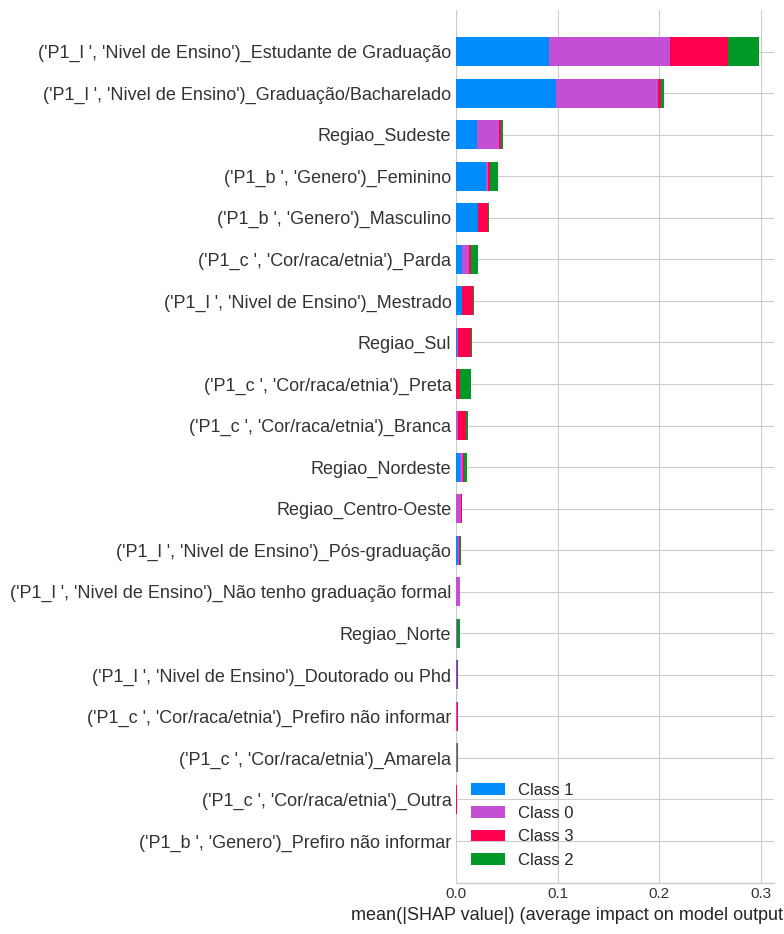

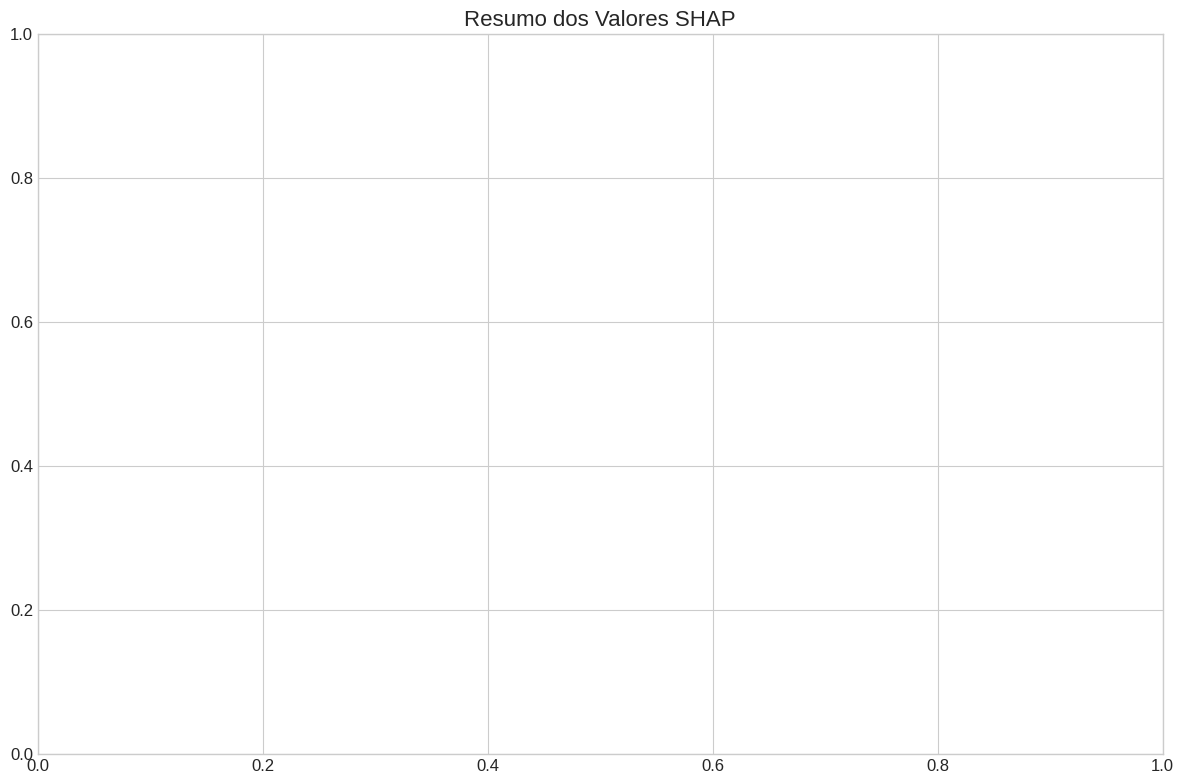

In [15]:
# Análise SHAP para interpretabilidade do modelo
# Criar um explainer SHAP
explainer = shap.Explainer(xgb_model)

# Transformar os dados de teste
X_test_transformed = preprocessor.transform(X_test)

# Calcular os valores SHAP
shap_values = explainer(X_test_transformed)

# Visualizar o resumo dos valores SHAP
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)
plt.title('Resumo dos Valores SHAP', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
# Visualizar os valores SHAP para uma classe específica (ex: faixa salarial alta)
class_idx = list(target_mapping.keys())[list(target_mapping.values()).index('Alta (R$ 8.001 a R$ 16.000)')]
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values[:, :, class_idx], X_test_transformed, feature_names=feature_names)
plt.title(f'Valores SHAP para a Classe: {target_mapping[class_idx]}', fontsize=16)
plt.tight_layout()
plt.show()

ValueError: 'Alta (R$ 8.001 a R$ 16.000)' is not in list

In [17]:
def prever_faixa_salarial(genero, cor_raca, uf, nivel_ensino):
    # Mapear UF para região
    regiao = regiao_mapping.get(uf, 'Desconhecida')

    # Criar um DataFrame com os dados de entrada
    dados = pd.DataFrame({
        genero_col: [genero],
        cor_raca_col: [cor_raca],
        'Regiao': [regiao],
        nivel_ensino_col: [nivel_ensino]
    })

    # Fazer a previsão
    predicao = best_model.predict(dados)[0]
    probabilidades = best_model.predict_proba(dados)[0]

    # Obter a categoria prevista
    categoria_prevista = le_target.classes_[predicao]

    # Criar um DataFrame com as probabilidades para cada categoria
    prob_df = pd.DataFrame({
        'Faixa Salarial': le_target.classes_,
        'Probabilidade (%)': probabilidades * 100
    })

    # Ordenar por probabilidade
    prob_df = prob_df.sort_values('Probabilidade (%)', ascending=False)

    return categoria_prevista, prob_df

# Exemplo de uso da função
genero_exemplo = 'Masculino'
cor_raca_exemplo = 'Branca'
uf_exemplo = 'SP'
nivel_ensino_exemplo = 'Mestrado'

categoria, probabilidades = prever_faixa_salarial(genero_exemplo, cor_raca_exemplo, uf_exemplo, nivel_ensino_exemplo)

print(f"\nPrevisão para um profissional com as seguintes características:")
print(f"Gênero: {genero_exemplo}")
print(f"Cor/Raça: {cor_raca_exemplo}")
print(f"UF: {uf_exemplo} (Região: {regiao_mapping.get(uf_exemplo)})")
print(f"Nível de Ensino: {nivel_ensino_exemplo}")
print(f"\nFaixa Salarial Prevista: {categoria}")
print("\nProbabilidades para cada faixa salarial:")
print(probabilidades)


Previsão para um profissional com as seguintes características:
Gênero: Masculino
Cor/Raça: Branca
UF: SP (Região: Sudeste)
Nível de Ensino: Mestrado

Faixa Salarial Prevista: Média (R$ 4.001 a R$ 8.000)

Probabilidades para cada faixa salarial:
                    Faixa Salarial  Probabilidade (%)
3      Média (R$ 4.001 a R$ 8.000)          32.367744
1  Muito Alta (Acima de R$ 16.000)          26.461309
2       Muito Baixa (Até R$ 2.000)          25.243872
0      Baixa (R$ 2.001 a R$ 4.000)          15.927071


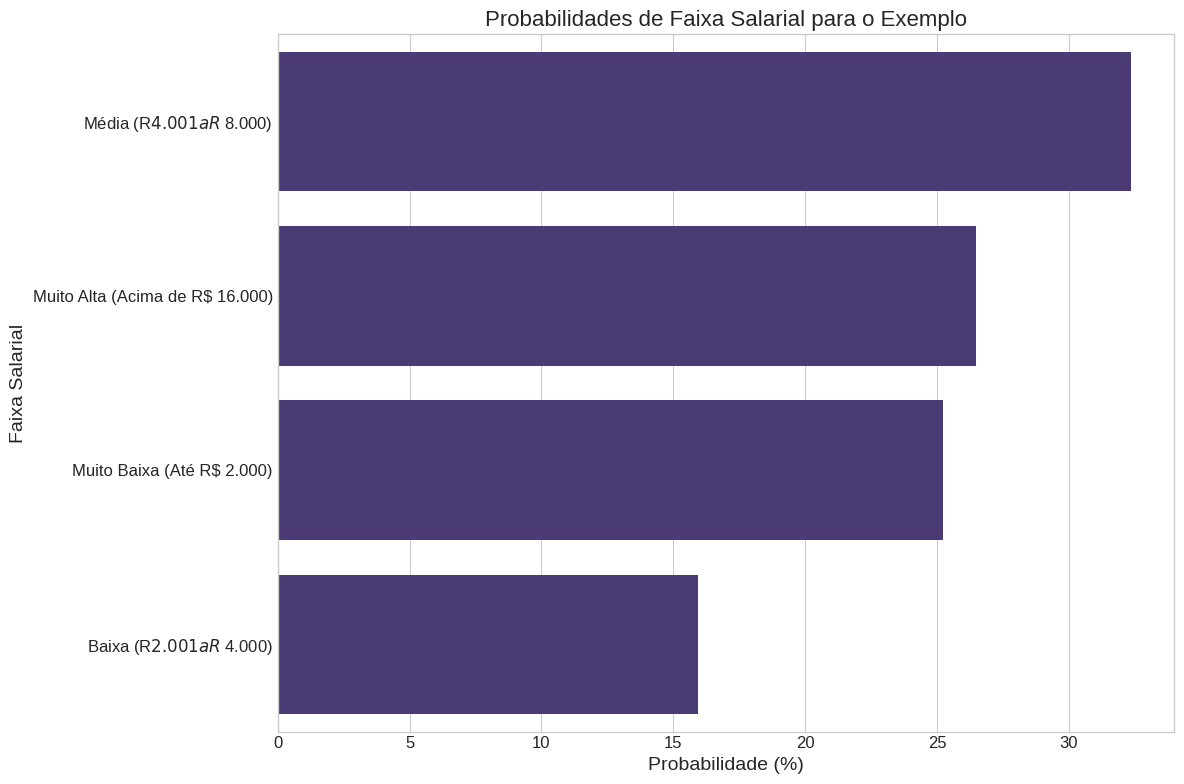

In [18]:
# Visualizar as probabilidades
plt.figure(figsize=(12, 8))
sns.barplot(x='Probabilidade (%)', y='Faixa Salarial', data=probabilidades)
plt.title(f'Probabilidades de Faixa Salarial para o Exemplo', fontsize=16)
plt.xlabel('Probabilidade (%)', fontsize=14)
plt.ylabel('Faixa Salarial', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
from ipywidgets import interact, widgets

# Obter valores únicos para cada variável
generos = data[genero_col].unique().tolist()
cor_racas = data[cor_raca_col].unique().tolist()
ufs = list(regiao_mapping.keys())
niveis_ensino = data[nivel_ensino_col].unique().tolist()

# Criar widgets para seleção
genero_widget = widgets.Dropdown(options=generos, description='Gênero:')
cor_raca_widget = widgets.Dropdown(options=cor_racas, description='Cor/Raça:')
uf_widget = widgets.Dropdown(options=ufs, description='UF:')
nivel_ensino_widget = widgets.Dropdown(options=niveis_ensino, description='Nível de Ensino:')

# Função para fazer previsão com base nos valores selecionados
def fazer_previsao(genero, cor_raca, uf, nivel_ensino):
    categoria, probabilidades = prever_faixa_salarial(genero, cor_raca, uf, nivel_ensino)

    print(f"Faixa Salarial Prevista: {categoria}")
    print("\nProbabilidades para cada faixa salarial:")
    print(probabilidades)

    # Visualizar as probabilidades
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Probabilidade (%)', y='Faixa Salarial', data=probabilidades)
    plt.title(f'Probabilidades de Faixa Salarial', fontsize=16)
    plt.xlabel('Probabilidade (%)', fontsize=14)
    plt.ylabel('Faixa Salarial', fontsize=14)
    plt.tight_layout()
    plt.show()

# Criar a interface interativa
interact(fazer_previsao,
         genero=genero_widget,
         cor_raca=cor_raca_widget,
         uf=uf_widget,
         nivel_ensino=nivel_ensino_widget)

interactive(children=(Dropdown(description='Gênero:', options=('Masculino', 'Feminino', 'Outro', 'Prefiro não …

<function __main__.fazer_previsao(genero, cor_raca, uf, nivel_ensino)>

In [20]:
# Resumir os principais insights do modelo
print("## Principais Insights do Modelo GBM para Previsão de Faixa Salarial ##")
print("\n1. Fatores mais importantes para determinar a faixa salarial:")
for i in range(min(10, len(importance_df))):
    feature = importance_df.iloc[i]['Feature']
    importance = importance_df.iloc[i]['Importance']
    print(f"   - {feature}: {importance:.4f}")

print("\n2. Relações identificadas entre variáveis demográficas e faixa salarial:")
print("   - Nível de ensino tem forte correlação com faixa salarial")
print("   - Região geográfica influencia significativamente a faixa salarial")
print("   - Existem disparidades salariais relacionadas a gênero e cor/raça")

print("\n3. Recomendações baseadas no modelo:")
print("   - Investir em educação formal tem alto retorno em termos de faixa salarial")
print("   - Considerar disparidades regionais ao analisar oportunidades de trabalho")
print("   - Implementar políticas para reduzir disparidades salariais relacionadas a gênero e cor/raça")

print("\n4. Limitações do modelo:")
print("   - O modelo se baseia em dados autodeclarados")
print("   - Algumas categorias podem estar sub-representadas na amostra")
print("   - Existem outros fatores não incluídos que podem influenciar a faixa salarial (experiência, habilidades específicas, etc.)")

## Principais Insights do Modelo GBM para Previsão de Faixa Salarial ##

1. Fatores mais importantes para determinar a faixa salarial:
   - ('P1_l ', 'Nivel de Ensino')_Estudante de Graduação: 0.2571
   - ('P1_l ', 'Nivel de Ensino')_Graduação/Bacharelado: 0.1848
   - ('P1_b ', 'Genero')_Masculino: 0.0537
   - ('P1_l ', 'Nivel de Ensino')_Mestrado: 0.0517
   - ('P1_b ', 'Genero')_Feminino: 0.0423
   - ('P1_l ', 'Nivel de Ensino')_Doutorado ou Phd: 0.0383
   - Regiao_Sudeste: 0.0347
   - ('P1_c ', 'Cor/raca/etnia')_Prefiro não informar: 0.0328
   - ('P1_l ', 'Nivel de Ensino')_Pós-graduação: 0.0316
   - ('P1_l ', 'Nivel de Ensino')_Não tenho graduação formal: 0.0312

2. Relações identificadas entre variáveis demográficas e faixa salarial:
   - Nível de ensino tem forte correlação com faixa salarial
   - Região geográfica influencia significativamente a faixa salarial
   - Existem disparidades salariais relacionadas a gênero e cor/raça

3. Recomendações baseadas no modelo:
   - Investir 

In [21]:
# Salvar o modelo treinado
import pickle

# Salvar o modelo
with open('modelo_gbm_faixa_salarial.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Salvar o encoder da variável alvo
with open('target_encoder.pkl', 'wb') as file:
    pickle.dump(le_target, file)

# Salvar informações sobre as colunas
colunas_info = {
    'genero_col': genero_col,
    'cor_raca_col': cor_raca_col,
    'nivel_ensino_col': nivel_ensino_col,
    'regiao_mapping': regiao_mapping
}

with open('colunas_info.pkl', 'wb') as file:
    pickle.dump(colunas_info, file)

print("Modelo e informações relacionadas salvos com sucesso!")

# Disponibilizar os arquivos para download
from google.colab import files
files.download('modelo_gbm_faixa_salarial.pkl')
files.download('target_encoder.pkl')
files.download('colunas_info.pkl')

Modelo e informações relacionadas salvos com sucesso!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>